# Assignment 3

- **Do not** change the function name that you are told to fill in
- **Do not** change the input argument of the function that you are told to fill in
- Before submitting this file, please rerun the entire notebook to make sure it works without any error
- **Do not** change the name of the file

In [51]:
%matplotlib inline

In [52]:
# import package DO NOT ADD OR REMOVE ANY OTHER PACKAGE
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

## Bayesian Linear Regression

We have learned in our theory assigment that we can update the paramters of Linear Regression using Bayes Rule. We consider the simplest form of Linear Regression, where the output $y \in \mathbb{R}$ and we have only single input variable $x \in \mathbb{R}$ or we want to estimate a line
$$
    y(x,\boldsymbol{\theta}) = \theta_0 + \theta_1 x
$$
Let's generate some data 

In [53]:
## Do NOT change
def gt_f(x):
    """ 
        ground truth function f(x) = theta_0 + theta_1 * x
    """
    
    return gt_theta[0] + gt_theta[1] * x

def plot_gaussian(ax, mean, cov):
    # this function is used to show Gaussian distribution
    x, y = np.mgrid[-1:2:0.1, -1:2:.01]
    pos = np.dstack((x, y))
    rv = multivariate_normal(mean.reshape(-1), cov)
    ax.contourf(x, y, rv.pdf(pos))
    ax.set_xlabel('$\\theta_0$'); ax.set_ylabel('$\\theta_1$')
    ax.scatter(gt_theta[0], gt_theta[1], c='r', label='True $\\boldsymbol{\\theta}$')
    ax.legend()

np.random.seed(3020)
# Set Up Data for the Straight Line problem
gt_theta = np.array([-0.2, 0.55]) # (2,) the true value of parameters
gt_function = gt_f
# create a set of 100 x values
line_x = np.linspace(-1,1,100) # (100,)
# calculate the correct value of y based on x and f
line_y = gt_function(line_x) # (100,)
# take n=30 points as obseved value
n = 30
# the variation in added noise in measurement
noise_sigma = 0.2
# create n random observed x 
data_x = np.random.rand(n) * 2 -1 # (n,)
# create n random observed y
data_y = gt_function(data_x) + np.random.randn(n) * noise_sigma # (n,)

Create a plot function to plot the true line, the data and the predicted data using `matplotlib`

**Note**: please remember to add the label of the data to the chart

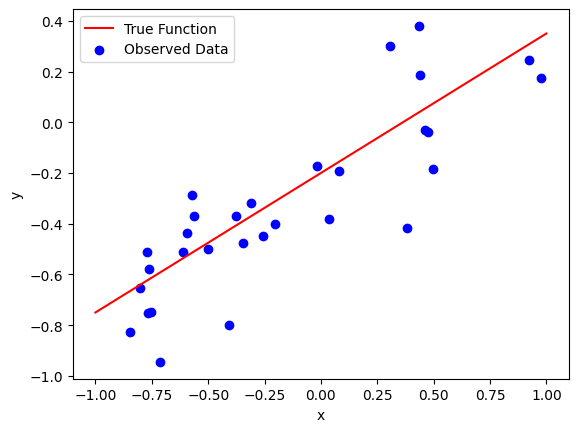

In [54]:
def plot(ax, line_x, line_y, data_x, data_y, pred_y=None):
    """
        Create a plot that have the true function, the observed data, and the prediction
        Args:
            ax: subplot Axes
            line_x: x-axis value of the true function
            line_y: y-axis value of the true function
            data_x: x-axis value of observed data
            data_y: y-axis value of observed data
            pred_y: (optional) predicted y-axis value of the estimated function given data_x
        Returns:
            None
    """
    
    ax.plot(line_x, line_y, label = 'True Function', color = 'red')

    ax.scatter(data_x, data_y, label = 'Observed Data', color = 'blue')
    if pred_y is not None:
        ax.plot(data_x, pred_y, label = 'Predicted Function', color = 'green')
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()

    
fig, ax = plt.subplots()
plot(ax, line_x, line_y, data_x, data_y)
plt.show()

Vectorize $x$, in order to work with Linear Algebra we usually try to vectorize the input $x$ so we can use Linear Algebra and make use of `numpy`. 

Therefore $f(x) =\theta_0 + \theta_1 x = \boldsymbol{\theta}^{T}\textbf{x}$

In [ ]:
# Vectorize x
def vectorize_x(data):
    """
    Takes 1-D data and maps it into [1, x] format.
    Args:
        data: 1-D numpy array of shape (n,)
    Returns:
        A 2-D numpy array of shape (n, 2), where each row is [1, x]
    """
    
    out = np.column_stack((np.ones(data.shape[0]), data))
    return out

data_x = vectorize_x(data_x) # (n,d)
targets = data_y.reshape(-1,1) # (n,1)

# print(data_x)
# print(targets)


[[ 1.         -0.5697059 ]
 [ 1.         -0.01600529]
 [ 1.          0.44142637]
 [ 1.         -0.56227483]
 [ 1.         -0.20346559]
 [ 1.         -0.50100138]
 [ 1.         -0.76132721]
 [ 1.          0.30686249]
 [ 1.         -0.31099562]
 [ 1.         -0.75501015]
 [ 1.         -0.40571561]
 [ 1.         -0.84667077]
 [ 1.          0.43649161]
 [ 1.         -0.61043963]
 [ 1.         -0.59270221]
 [ 1.         -0.77230864]
 [ 1.          0.97789003]
 [ 1.          0.0792009 ]
 [ 1.          0.46055218]
 [ 1.         -0.7654249 ]
 [ 1.         -0.25518702]
 [ 1.          0.49568262]
 [ 1.         -0.37459816]
 [ 1.         -0.80046734]
 [ 1.         -0.34702403]
 [ 1.         -0.71420954]
 [ 1.          0.92207907]
 [ 1.          0.38328713]
 [ 1.          0.03687099]
 [ 1.          0.47288104]]
[[-0.28486372]
 [-0.17240821]
 [ 0.18602348]
 [-0.36838217]
 [-0.4020962 ]
 [-0.49942952]
 [-0.5804201 ]
 [ 0.30261901]
 [-0.3197811 ]
 [-0.7500728 ]
 [-0.79905222]
 [-0.82806308]
 [ 0.3799

Use the formulation in theory question to update $\mu_1$ and $\Sigma_1$
$$
\boldsymbol{\mu}_1 = \boldsymbol{\Sigma}_1(\boldsymbol{\Sigma_0}^{-1}\boldsymbol{\mu}_0 + \sigma^{-2}\boldsymbol{X}^{T}\boldsymbol{y})
$$
$$
\boldsymbol{\Sigma}_{1}^{-1} = \boldsymbol{\Sigma}_{0}^{-1} + \sigma^{-2}\boldsymbol{X}^{T}\boldsymbol{X}
$$

In [56]:
def update_w_mean_and_cov(old_w_mean, old_w_cov, data_x, targets, noise_sigma):
    """
    Update the posterior mean and covariance of weights.
    Args:
        old_w_mean: Prior mean of weights (shape: (d, 1)).
        old_w_cov: Prior covariance of weights (shape: (d, d)).
        data_x: Design matrix (shape: (n, d)).
        targets: Target values (shape: (n, 1)).
        noise_sigma: Standard deviation of noise.
    Returns:
        theta_mean: Updated posterior mean of weights (shape: (d, 1)).
        theta_cov: Updated posterior covariance of weights (shape: (d, d)).
    """
    
    noise_inv = 1 / (noise_sigma ** 2)

    sigma_inv = np.linalg.inv(old_w_cov)
    
    theta_cov = np.linalg.inv(sigma_inv + noise_inv * data_x.T @ data_x)
    
    theta_mean = theta_cov @ (sigma_inv @ old_w_mean + noise_inv * data_x.T @ targets)
    
    return theta_mean, theta_cov



In [57]:
def run_simple_blr_model(initial_theta_mean, initial_theta_cov, line_x, line_y, data_x, data_y, features, targets, noise_sigma):
    """
    Visualize the posterior distribution of theta as more data is observed.
    Args:
        initial_theta_mean: Prior mean of theta (shape: (d, 1)).
        initial_theta_cov: Prior covariance of theta (shape: (d, d)).
        line_x: True function x-values.
        line_y: True function y-values.
        data_x: Observed x-values.
        data_y: Observed y-values.
        features: Design matrix (vectorized data_x).
        targets: Target values (reshaped data_y).
        noise_sigma: Standard deviation of noise.
    Returns:
        None
    """

    if initial_theta_mean is None or initial_theta_cov is None:
        print("value for mean or cov is None")
        return
    
    fig, ax = plt.subplots()
    plot_gaussian(ax, initial_theta_mean, initial_theta_cov)
    plt.title('Prior over $\\boldsymbol{\\theta}$')
    plt.show()
    subsets = [1, 2, 10, 30]

    theta_mean = initial_theta_mean
    theta_cov = initial_theta_cov
    
    for subset in subsets:
        subset_x = features[:subset] 
        subset_y = targets[:subset] 
        
        theta_mean, theta_cov = update_w_mean_and_cov(theta_mean, theta_cov, subset_x, subset_y, noise_sigma)
        
        fig, ax = plt.subplots()
        plot_gaussian(ax, theta_mean, theta_cov)
        plt.title(f'Posterior over $\\boldsymbol{{\\theta}}$ after {subset} data points')
        plt.show()
        
        pred_y = (vectorize_x(data_x[:, 1]) @ theta_mean).flatten()
        
        fig, ax = plt.subplots()
        plot(ax, line_x, line_y, data_x[:, 1], data_y, pred_y)
        plt.title(f'Updated prediction after {subset} data points')
        plt.show()

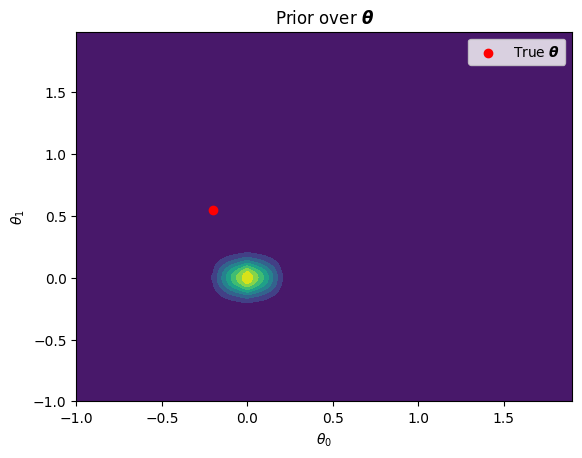

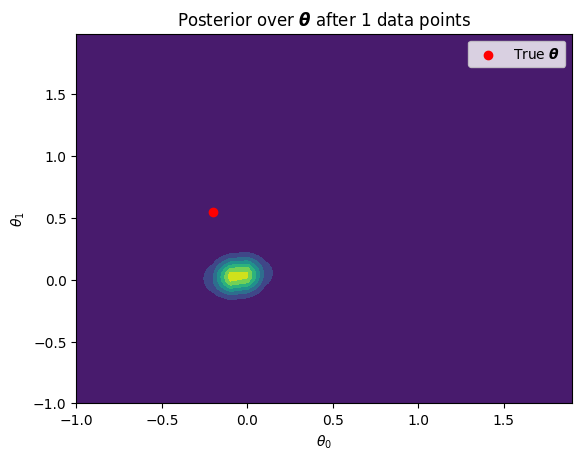

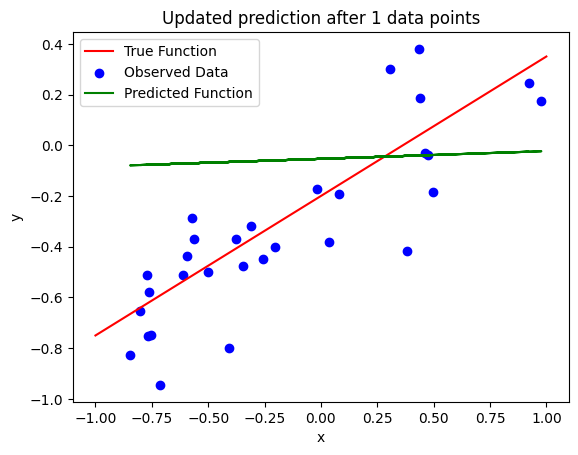

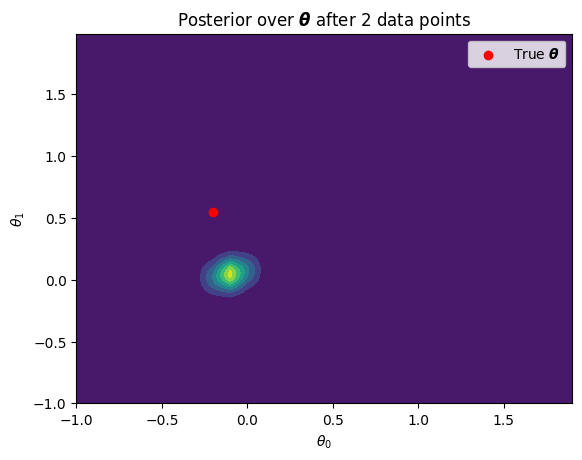

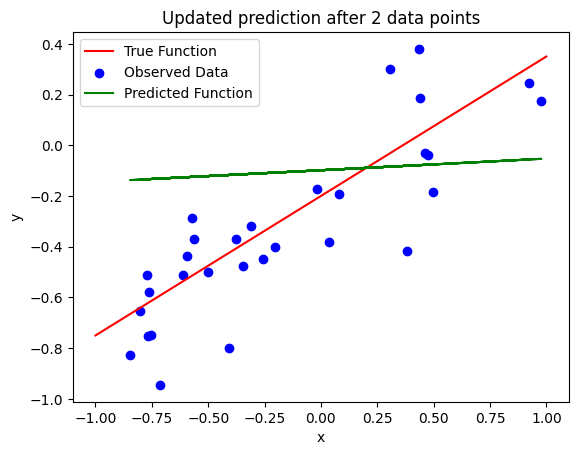

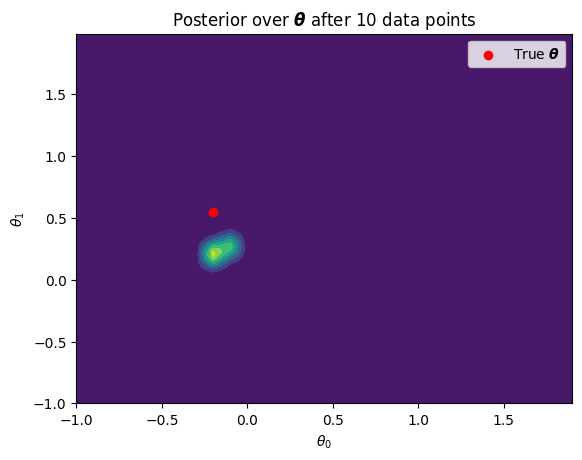

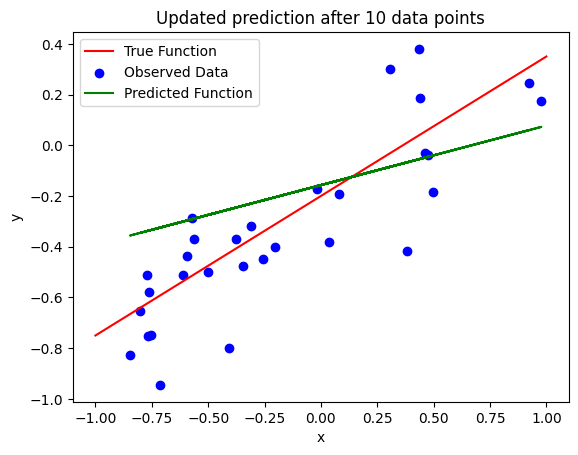

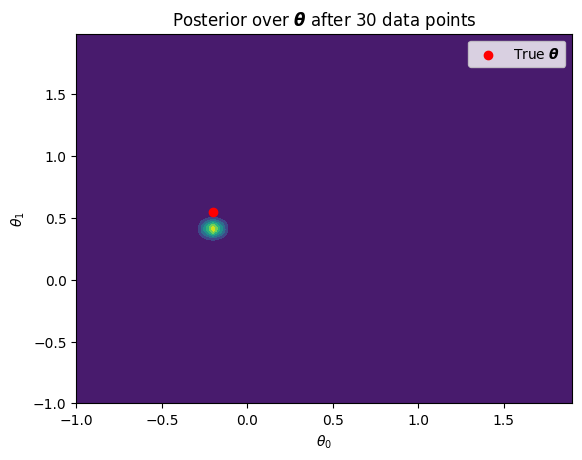

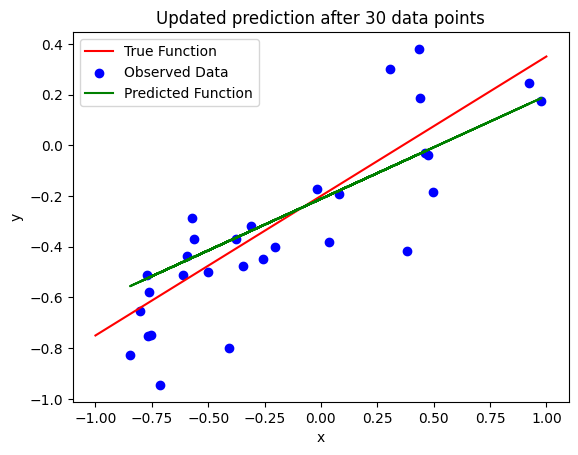

In [58]:
initial_theta_mean = np.array([0,0]).reshape(2,1) # (d,1)
initial_theta_cov = 0.01*np.eye(2) # (d,d)

run_simple_blr_model(initial_theta_mean, initial_theta_cov, line_x, line_y, data_x, data_y, data_x, targets, noise_sigma)

You can see that the result is not good, try to change the initial value to have a better result

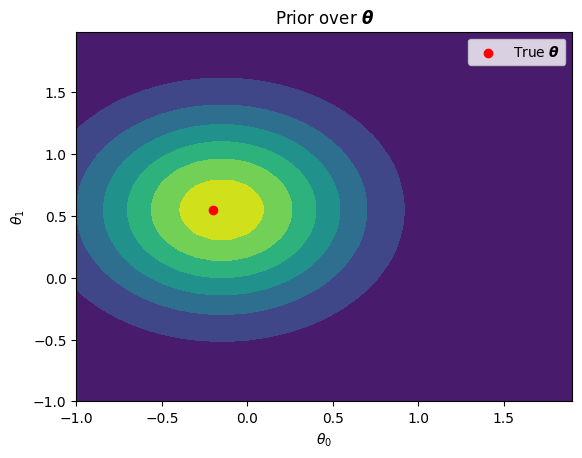

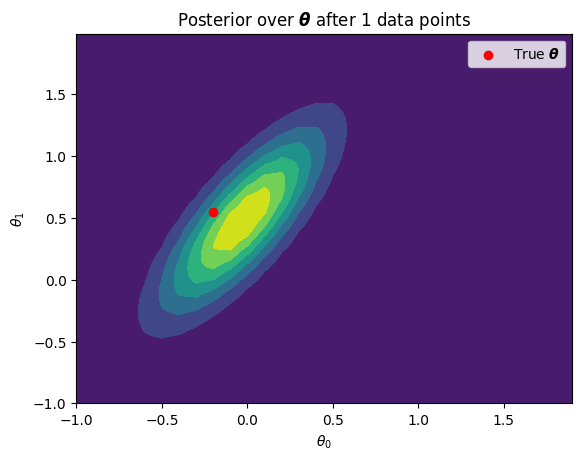

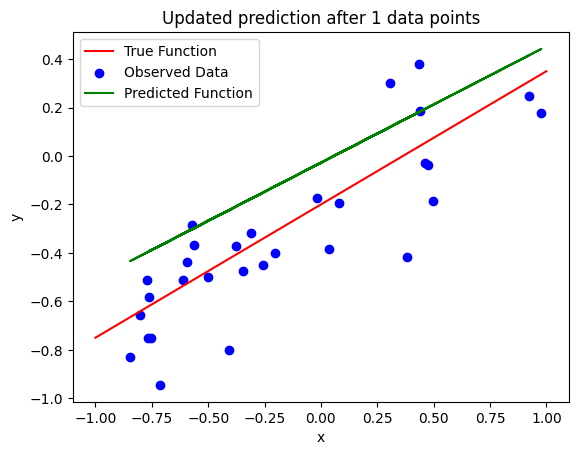

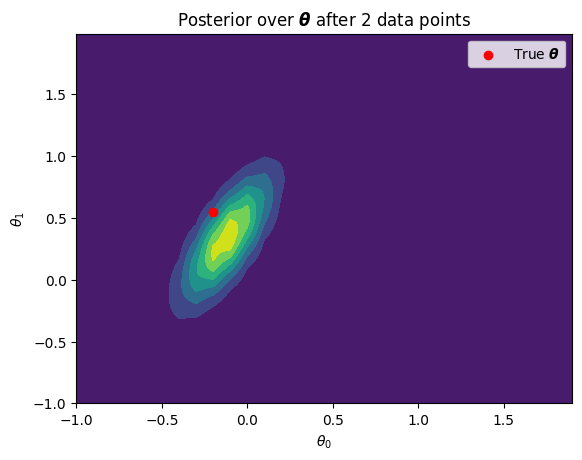

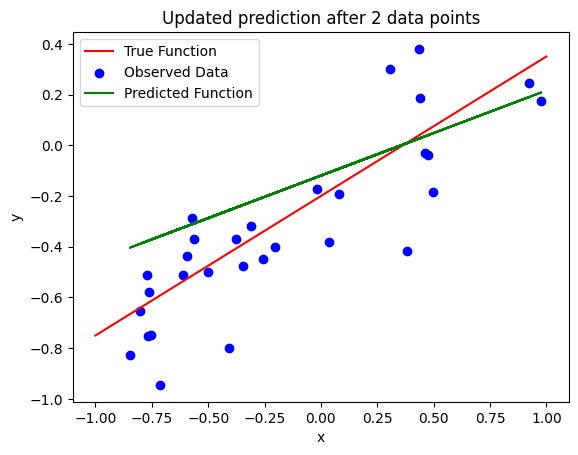

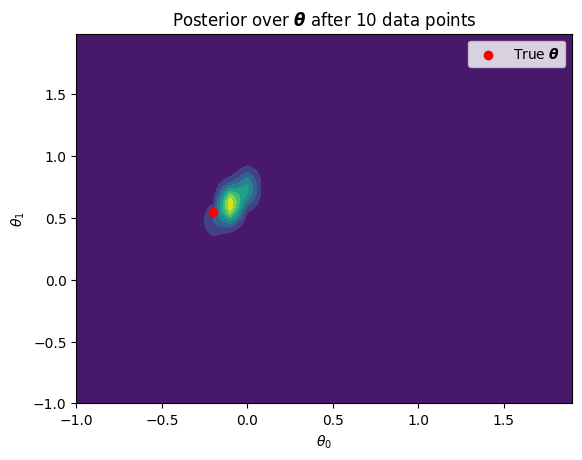

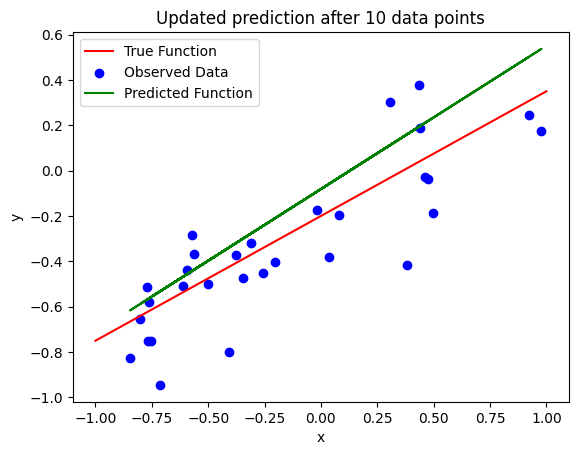

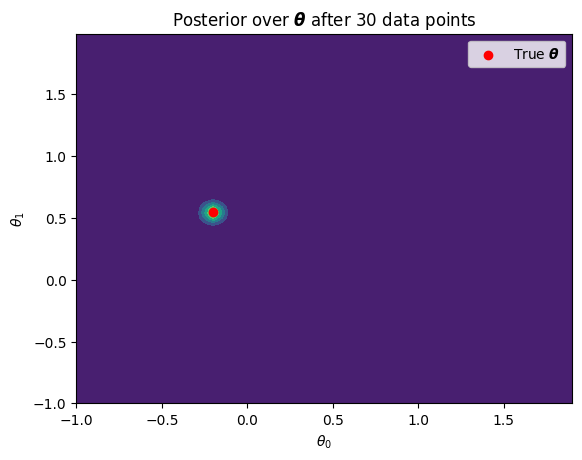

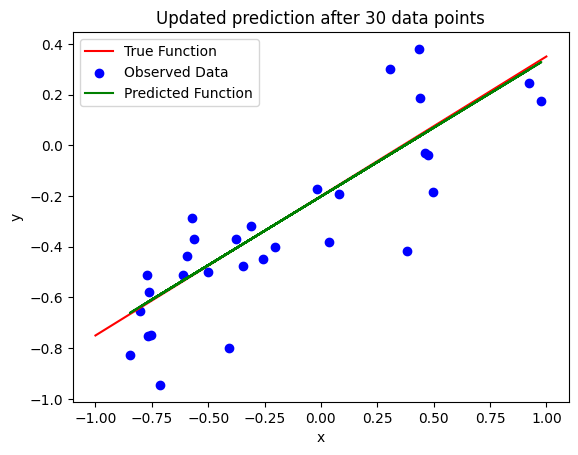

In [59]:
initial_theta_mean = np.array([-0.15, 0.55]).reshape(2,1) # TODO
initial_theta_cov = 0.3 * np.eye(2) # TODO

run_simple_blr_model(initial_theta_mean, initial_theta_cov, line_x, line_y, data_x, data_y, data_x, targets, noise_sigma)